# Boston Crime Analysis & Map Visualizations
## Developed by Charles Karafotias
### CMSC320-0101: Introduction To Data Science Final Project

# Introduction
Crime has always been an issue in the United States of America. Whether it be gun violence, trespassing offenses, or more serious felony offenses, crime rates are a major consideration in choosing where to live and when citizens deem it safe to exit the safety of their homes. In the United States overall, crime rates have been on the decline according to Pew Research Center (read more [here](https://www.pewresearch.org/fact-tank/2020/11/20/facts-about-crime-in-the-u-s/)) yet "Americans tend to believe crime is up" even with the extensive research that has been done into this topic (Gramlich). With the changing times since the publication of the previously mentioned article and the ongoing effects of the COVID-19 pandemic, I am interested in analyzing the affects of crime rates that currently exist in a major city of the United States. 

Of the many crime datasets that are available to the public, I am particularly interested in analyzing the city of Boston, Massachusetts crime rates and finding out if there are patterns in the types of crimes that exist in different neighborhoods of the city. Provided by the city of Boston, the **Crime Incident Reports (August 2015 - To Date) (Source: New System)** dataset located [here](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system) provides a plethora of data for analysis. I specifically chose to analyze the crime in the city of Boston as there is 44 higher level institutions in the metropolitan area alone and many others around the city (more information [here](https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_metropolitan_Boston)). With all of the student population coming and going during the college semesters, I pose the following questions that this project aims to answer:
1.  Does the crime rate increase during the college semesters (Fall and Spring semesters)?
2.  What are the most popular crimes during the college semesters in the most populated college neighborhoods?
3.  How does the crime rate differ between the work week and the weekend during the college semester?
4.  During college breaks, does the city of Boston experience different frequencies of common crimes?
5.  How do different neighborhoods crime frequency compare?

In order to answer the above questions, I walk through the data science pipeline. This consists of data collection, data processing, exploratory analysis and data visualizations, analysis & hypothesis testing, and decision making based off the results. Each section is walked through below.

## Requirements For Code
The language selected for this project is Python. With Python, the above questions can be answered using the pipeline provided. I elected to use Python as there are many additional libraries (listed below) that provide valuable tools for data science. I have provided a list of the libraries that have been used throughout the project and links to the accompanying API for further reading. 
1. [Numpy](https://numpy.org/doc/stable/reference/)
2. [Pandas](https://pandas.pydata.org/docs/reference/index.html)
3. [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/#)
4. [os](https://docs.python.org/3/library/os.html)
5. [requests](https://docs.python-requests.org/en/latest/)
6. [shutil](https://docs.python.org/3/library/shutil.html#module-shutil)
7. [Matplotlib](https://matplotlib.org/)
8. [collections-defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict)

# Data Collection
The first step of the data science pipeline is to collect the data. In this process, the datasets that are needed for the project are downloaded or gatherered from their respective sources. For this process, I have developed a script that will organize the data into the proper format if the data is available from the Boston city website. This will ensure that there is always updated data, as the dataset is being updated every year. 

The script below begins by importing the required libraries and modules. These are requests, os, shutil, and BeautifulSoup. The requests and BeautifulSoup libraries are needed in order to access the Boston crime dataset website and the BeautifulSoup library is used in order to parse the content that is returned by the requests library get call. The os and shutil modules were used to make simple calls such as making a directory and removing old directories. 

Following import calls, the script has the following flow:
1. Declaration of a request object where the get() function is called with the url to the Boston crime data.
2. If the website returns a 200 code, meaning that the website is up, then it is safe to interact with the webpage. If the response is not 200, then the script looks for old data. This would be located at './Data'. If this exists, this data is used. If both do not exist, the the program errors out and informs the user promptly.
3. When 200 code is returned, a BeautifulSoup object is instantiated and is set to read the html that is returned from the requests. From here, the script finds all links that are stored with the class id 'btn btn-primary'. This class contains all of the links to the .csv and .xlsx files that will need to be downloaded for analysis in the project later on. 
4. Once the links are found, they are stored in a list called links. Following this, if the old folder called 'Data' still exists, this is replaced with a new 'Data' folder. If the folder doesn't exist, then the new folder is created. Then, the csv files are downloaded and stored in the 'Data' folder that was created with the proper naming. The scheme for the naming is c1, c2, ... representing 'crime' and the 'link number'. 

In [1]:
# Import the needed libraries for this section. This allows for obtaining the HTML and parsing the HTML code
import requests
from bs4 import BeautifulSoup 
import os
import shutil

r = requests.get('https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system')
if r.status_code == 200:
    soup = BeautifulSoup(r.content, 'html.parser')
    links = []
    # Find all href links that contain the class btn btn-primary These are the ones that are downloadable .csv 
    # files that have the data needed for project
    for link in soup("a", "btn btn-primary", href=True):
        links.append(link['href'])

    # Download each of the links, then store in proper place
    if 'Data' in os.listdir('.'):
        # remove Data folder, make new folder then add in .csv files from online
        shutil.rmtree('./Data')
    
    # make filder then add in .csv files
    os.mkdir('./Data')
    for index,curr_url in enumerate(links):
        r = requests.get(curr_url, allow_redirects=True)
        fileExt = curr_url.split('.')[-1]
        fileName = f'./Data/c{index+1}.{fileExt}'
        open(fileName, 'wb').write(r.content)       
elif 'Data' in os.listdir('.'):
    # Use this data instead
    print('Using old dataset saved. Failed to retrieve updated data from website.')
else:
    raise Exception('Failed to retrieve data from website and failed to find Data directory in current directory')

# Data Parsing & Organization 

The next step in the data science pipeline is to parse the downloaded data from the data collection step and organize it in a way that can be used for the following parts of the pipeline. This important step insures that are data is clean of any mislabeled data or unavailable data and that data between two different .csv files are the same format. 

For parsing and organizing the data, I elected to use the Pandas library of Python. Use of this library allows the script below to easily read in the downloaded data, format it into Python objects, and combime the data together into one DataFrame object that spans all the years. 

The script performs the following actions to parse and organize the data:
1. First, the necessary libraries were imported. The only new library that has not been used yet that needed importing was Pandas. 
2. Next, teh script extract just the relative paths of the .csv files. These are the files that contain the crime data for each year that need to be parsed and organized. This is done by adding the paths of files that end in .csv to a list.
3. From here, Pandas is used to load in each .csv file as a DataFrame object. These objects are then stored into the list named frames. Since read_csv was used, the script standardizes the types that are expected for each category manually rather than leaving dtype guessing up to Pandas. This ensures that the columns are of the same type throughout each of the DataFrame objects.
4. With the DataFrames that were saved into frames, the script concatenates each of the frames together into one large DataFrame object called data. This contains all the crimes over all the years before cleaning has happened.
5. The script organizes the data by removing crimes that do not have proper location tags. This is because there exist some entries in the data that only have street names with no corresponding location tag. Further, the data that does not have location tags appear to be a majority of data that was migrated from the old system to the new system, suggesting that for some types of crimes in the past, this data was not kept.

In [2]:
# Imports of necessary libraries/modules needed
import pandas as pd

# Extract the .csv files from the ./Data folder. These csv files contain the crime data
# that needs to be sorted and organized.
csvPaths = []
for file in os.listdir('./Data/'):
    if '.csv' in file:
        csvPaths.append(os.path.join('./Data',file))
    
# Using pandas, load in each csv file and add it to the data DataFrame object.
frames = []
for file in csvPaths:
    dtypes = {'INCIDENT_NUMBER': str, 'OFFENSE_CODE':int, 'OFFENSE_CODE_GROUP':str, 'OFFENSE_DESCRIPTION':str, 
             'DISTRICT': str, 'REPORTING_AREA': str, 'SHOOTING': str, 'OCCURRED_ON_DATE': str, 'YEAR': int, 
             'MONTH': int, 'DAY_OF_WEEK': str, 'HOUR': int, 'UCR_PART': str, 'STREET': str, 'Lat': float, 
             'Long': float, 'Location': str}
    temp = pd.read_csv(file, dtype=dtypes, parse_dates = ['OCCURRED_ON_DATE'])
    frames.append(temp)

# Concatenate each frame into one DataFrame object called data
data = pd.concat(frames)

# Organize the data DataFrame by removing incidents do not have proper Location tag. This would be (0,0)
data = data.loc[data['Location'] != '(0, 0)']
data

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
5,I192078556,2500,NaN,Migrated Report - Kidnapping,A1,,0,2019-09-28 20:49:00,2019,9,Saturday,20,NaN,WASHINGTON ST,42.349973,-71.063488,"(42.3499725621905, -71.0634881686036)"
6,I192078556,2511,NaN,KIDNAPPING - ENTICING OR ATTEMPTED,A1,123,0,2019-09-28 20:49:00,2019,9,Saturday,20,NaN,WASHINGTON ST,42.349973,-71.063488,"(42.3499725621905, -71.0634881686036)"
11,I192078529,800,NaN,Migrated Report - Assault/Assault & Battery,E5,,0,2019-09-27 23:00:00,2019,9,Friday,23,NaN,EDGEMERE RD,42.258676,-71.151165,"(42.2586763744759, -71.1511647925742)"
23,I192078509,619,NaN,LARCENY ALL OTHERS,D4,167,0,2019-09-28 18:00:00,2019,9,Saturday,18,NaN,WAREHAM ST,42.339314,-71.067489,"(42.3393144890309, -71.0674892597477)"
44,I192078478,724,NaN,AUTO THEFT,A1,111,0,2019-09-27 23:00:00,2019,9,Friday,23,NaN,TREMONT ST,42.354284,-71.063804,"(42.3542837724149, -71.0638040374747)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53592,I080542626-00,3125,Warrant Arrests,WARRANT ARREST,A1,111,NaN,2015-08-12 12:00:00,2015,8,Wednesday,12,Part Three,BOYLSTON ST,42.352312,-71.063705,"(42.35231190, -71.06370510)"
53593,I080542626-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,A1,111,NaN,2015-08-12 12:00:00,2015,8,Wednesday,12,Part Two,BOYLSTON ST,42.352312,-71.063705,"(42.35231190, -71.06370510)"
53594,I080542626-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,A1,111,NaN,2015-08-12 12:00:00,2015,8,Wednesday,12,Part Two,BOYLSTON ST,42.352312,-71.063705,"(42.35231190, -71.06370510)"
53595,I030217815-08,3125,Warrant Arrests,WARRANT ARREST,E18,520,NaN,2015-07-09 13:38:00,2015,7,Thursday,13,Part Three,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)"


# Exploratory Data Analysis

The next step of the data science pipeline is exploratory data analysis. This section of the notebook is where I begin to explore the data DataFrame object made in the previous step. I specifically set out in the following code to explore the patterns of the data and to answer the questions posed at the beginning of the notebook:

1.  Does the crime rate increase during the college semesters (Fall and Spring semesters)?
2.  What are the most popular crimes during the college semesters in the most populated college neighborhoods?
3.  How does the crime rate differ between the work week and the weekend during the college semester?
4.  During college vacation periods, does Boston's top crimes change in each district?
5.  How do different districts crime frequency compare?

Below, I wrote the following code to answer the questions above. The process for answering each of the questions is as follows: 

**For Question 1)** I first begin by defining the average Fall and Spring semesters of Boston area universities. From my [research](https://www.campusexplorer.com/college-advice-tips/D3ABFFE6/The-College-Academic-Calendar/#:~:text=Spring%20semester%20runs%20from%20January,from%20January%2016%2DMay%2025.), I found that on average this period is from mid-August to the beginning of December for Fall semesters and January through late April to early May for Spring semesters. I elected to use [Northeastern University's dates](https://registrar.northeastern.edu/wp-content/uploads/sites/9/2021-2022-UG-Expanded-Calendar-List.pdf?) as parameters for defining Fall and Spring semester in the code since this school is located in the heart of Boston. This means fall semester start, *monthF*, is September and fall semester end, *monthFEnd*, is December. For spring semester start, *monthS*, January is set and for *monthSEnd* it is set to April since the finals end near the end of April to the beginning of May. From here, I create two dataframes, *dfSemester* and *dfVacation* to represent the crimes that occurred during each of the time periods. Then, I plot the crimes per month rate for each dataframe and compare them. This was done since there are twice as many months during the school semesters so the total number of crimes will not be helpful insight. A bar graph is used to show this difference.

Text(0, 0.5, 'Rate of Crimes Per Month')

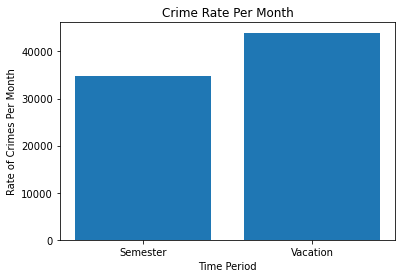

In [3]:
# Imports needed for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Question 1 Code
monthF = 9 
monthFEnd = 12 
monthS = 1
monthSEnd = 4
# Make 2 dataframes, one for crimes during semesters and the other for crimes outside semesters
dfSemester = data[((data['MONTH']>=monthF) & (data['MONTH']<=monthFEnd)) | ((data['MONTH']>=monthS) & (data['MONTH']<=monthSEnd))]
dfVacation = data[(data['MONTH']>monthSEnd) & (data['MONTH']<monthF)]
semesterCrimeRate = len(dfSemester)/9
vacationCrimeRate = len(dfVacation)/4
plt.bar(['Semester','Vacation'],[semesterCrimeRate,vacationCrimeRate])
plt.title('Crime Rate Per Month')
plt.xlabel('Time Period')
plt.ylabel('Rate of Crimes Per Month')

From the code block and visualization produced above, I was able to conclude for question 1 that there is an increase in crime rate when during the vacation period than when there are students in the city full time. 

**For Question 2)** In order to solve this question, I started by identifying the neighborhoods where there are a lot of universities. A map of the Boston Police Department’s districts can be found [here](http://20yrhomicide.blackstonian.org/by-police-district/). With this map, I then looked up all the universities that fall into each of these districts. My findings are below, [using this list for colleges in Boston](https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_metropolitan_Boston):

District A-1 (Beacon Hill, Chinatown, Downtown, North End): 5

District A-7 (East Boston): 0

District A-15 (Charlestown): 4

District B-2 (Mission Hill, Roxbury): 1

District B-3 (Mattapan, North Dorchester): 0

District C-6 (South Boston): 1

District C-11 (Dorchester): 0

District D-4 (Back Bay, Fenway, South End): 14

District D-14 (Allston, Brighton): 2

District E-5 (Roslindale, West Roxbury): 0

District E-13 (Jamaica Plain): 1

District E-18 (Hyde Park): 0

From above, I concluded that districts D-4, A-1, A-15, D-14, B-2, C-6, and E-13 are relevant for this question. Using Pandas value_counts function, I then found the most frequently committed offense in each of the regions with students in them. Then, I matched the offense code with the offense description in the table. This will be the x-axis labels for the plots. From this data, I was interested in finding the frequency of these crimes and how many districts shared the same top crime. To do this, I extracted the corresponding data from the value_counts returned sequence object and then created a subplot of the data below. The left plot shows the number of districts that share the same top crime and the right subplot shows the frequency of each of these top crimes.

Text(0.5, 1.0, 'Offenses in College Districts')

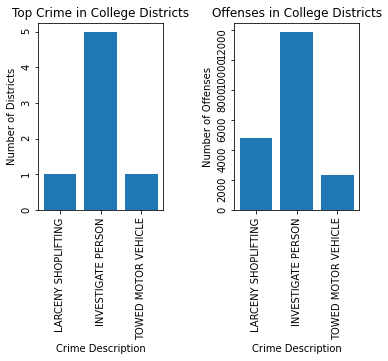

In [4]:
# Question 2 Code
# Importing required modules for this section
from collections import defaultdict

crimesD4 = data[data['DISTRICT']=='D4']
crimesA1 = data[data['DISTRICT']=='A1']
crimesA15 = data[data['DISTRICT']=='A15']
crimesD14 = data[data['DISTRICT']=='D14']
crimesB2 = data[data['DISTRICT']=='B2']
crimesC6 = data[data['DISTRICT']=='C6']
crimesE13 = data[data['DISTRICT']=='E13']

# Use OFFENSE_CODE and count frequency of each code. Find the highest.
districts = [crimesD4,crimesA1,crimesA15,crimesD14,crimesB2,crimesC6,crimesE13]
crimeDistrictCount = defaultdict(int)
crimeFreq = defaultdict(int)
for district in districts:
    counts = district['OFFENSE_CODE'].value_counts()
    highest = counts.iloc[:1].index[0]
    freqHighest = counts.iloc[0]
    crimeDesc = data[data['OFFENSE_CODE']==highest]['OFFENSE_DESCRIPTION'].iloc[0]
    crimeDistrictCount[crimeDesc] += 1
    crimeFreq[crimeDesc] += freqHighest

# Plot top crimes in districts and the frequency of these crimes in the dataset.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)
ax1.bar(crimeDistrictCount.keys(), crimeDistrictCount.values())
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Crime Description')
ax1.set_ylabel('Number of Districts')
ax1.set_title('Top Crime in College Districts')
ax2.bar(crimeFreq.keys(), crimeFreq.values())
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Crime Description')
ax2.set_ylabel('Number of Offenses')
ax2.set_title('Offenses in College Districts')

From the code block and visualization produced above, I was able to conclude for question 2 that the top crime committed in the college populated districts of Boston are cases where a person is being investigated. There were 5 of the 7 districts that had this as the top crime entry in the dataset. Further, I was able to conclude that the amount of these cases is much larger than the other crimes. This is most likely because there are multiple districts that contributed to this top crime while the larceny shoplifting and towed motor vehicle offenses only occurred in the other two districts.

**For Question 3)** I began by dividing the data into time periods where students are in university studying. This is the same process that was done for question 1. From this new DataFrame, I then extracted the weekday and weekends into 2 DataFrame objects for analysis. I then computed the crime rate per day for the 2 DataFrames to see if there were more crimes committed during the week or during the weekend.

Text(0, 0.5, 'Crime Rate Per Day')

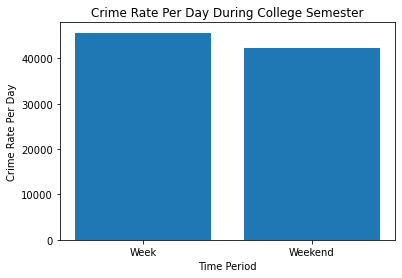

In [5]:
# Question 3 Code
# Defining the months that the universities are in session in Boston. Using same assumptions as question 1
monthF = 9 
monthFEnd = 12 
monthS = 1
monthSEnd = 4
# Make a semester DataFrame object
dfSemester = data[((data['MONTH']>=monthF) & (data['MONTH']<=monthFEnd)) | ((data['MONTH']>=monthS) & (data['MONTH']<=monthSEnd))]
# Set days of weekend
weekend = ['Saturday', 'Sunday']
# create week and weekend DataFrames
dfWeekend = dfSemester[dfSemester['DAY_OF_WEEK'].isin(weekend)]
dfWeek = dfSemester[~(dfSemester['DAY_OF_WEEK'].isin(weekend))]
# Compute the crime rate per day for week and weekend
cRWeek = len(dfWeek)/5
cRWeekend = len(dfWeekend)/2
# Plot the crime rates 
plt.bar(['Week', 'Weekend'],[cRWeek,cRWeekend])
plt.title('Crime Rate Per Day During College Semester')
plt.xlabel('Time Period')
plt.ylabel('Crime Rate Per Day')

From the code block and visualization produced above, I was able to conclude for question 3 that there are more crimes committed per day during the week(M-F) than during the weekends during the college semester. The different wasn't as large as I initially expected.

**For Question 4)** I began by first dividing the initial *data* DataFrame into 2 DataFrames to represent the semester and vacation time periods similar to the steps taken in questions 1 and 3. From here, I found the top crimes for each district during the semester and vacation time periods. This was done in a similar way to that of question 2 using the value_counts functions. I then created 2 dictionaries to hold the results for each district, called *districtSemesterTop* and *districtVacationTop*. These hold a tuple in the values section which consists of the crime description and the frequency of that top crime. From here, I created a plot that contains two bars, the left which represents the semester and the right bar which is the vacation time period's top crime. The height of the bars is the number of crime occurrences that occurred in the dataset for that top crime during the selected time period. I also created unique colors for each unique crime description that existed. This allows for comparison to see if the top crime in a particular district changes during the different time periods.

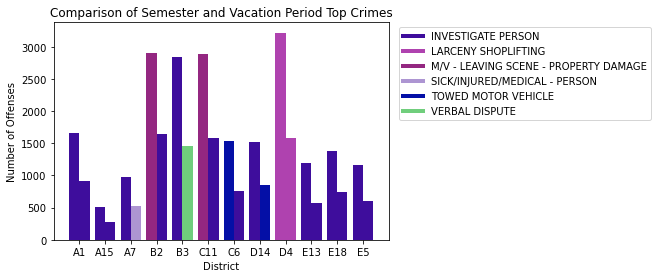

In [6]:
# Question 4 Code
# Importing necessary packages
import numpy as np
from matplotlib.lines import Line2D

# Defining months for the semester time period
monthF = 9 
monthFEnd = 12 
monthS = 1
monthSEnd = 4

# Make 2 dataframes, one for crimes during semesters and the other for crimes outside semesters
dfSemester = data[((data['MONTH']>=monthF) & (data['MONTH']<=monthFEnd)) | ((data['MONTH']>=monthS) & (data['MONTH']<=monthSEnd))]
dfVacation = data[(data['MONTH']>monthSEnd) & (data['MONTH']<monthF)]

# Create dataframes for each district during the semester and vacation
# Get the districts in the dataset, removing the nan and External districts since they are not relevant
districts = np.unique(list(dfSemester['DISTRICT']))[:-2]

dfDistrictsSemester = {}
dfDistrictsVacation = {}
for district in districts:
    dfDistrictsSemester[district] = dfSemester[dfSemester['DISTRICT']==district]
    dfDistrictsVacation[district] = dfVacation[dfVacation['DISTRICT']==district]
    
# go through districts and find the top crime, frequency, and description for each
districtSemesterTop = {}
districtVacationTop = {}
for district in districts:
    currSemDf = dfDistrictsSemester[district]
    currVacDf = dfDistrictsVacation[district]
    # find frequencies Semester time period
    countsSem = currSemDf['OFFENSE_CODE'].value_counts()
    highestSem = countsSem.iloc[:1].index[0]
    crimeDescSem = currSemDf[currSemDf['OFFENSE_CODE']==highestSem]['OFFENSE_DESCRIPTION'].iloc[0]
    freqHighestSem = countsSem.iloc[0]
    # find frequencies Vacation time period
    countsVac = currVacDf['OFFENSE_CODE'].value_counts()
    highestVac = countsVac.iloc[:1].index[0]
    crimeDescVac = currVacDf[currVacDf['OFFENSE_CODE']==highestVac]['OFFENSE_DESCRIPTION'].iloc[0]
    freqHighestVac = countsVac.iloc[0]
    districtSemesterTop[district] = (crimeDescSem,freqHighestSem)
    districtVacationTop[district] = (crimeDescVac,freqHighestVac)


# get list of descriptions
semDesc = [(list(x)[:])[0] for x in districtSemesterTop.values()]
vacDesc = [(list(x)[:])[0] for x in districtVacationTop.values()]
# get list of frequency values
semFreq = [(list(x)[:])[1] for x in districtSemesterTop.values()]
vacFreq = [(list(x)[:])[1] for x in districtVacationTop.values()]

# Plot the frequency values and then see if bar values can be set based off value of description. 
X_axis = np.arange(len(districtSemesterTop.keys()))
# Creates colors for each unique crime description that exists between semester and vacation descriptions
colors = []
allDesc = semDesc + vacDesc
uniqueDescs = np.unique(allDesc)
colorDesc = {}
for i in uniqueDescs:
    r = np.random.uniform(0,1)
    g = np.random.uniform(0,1)
    b = np.random.uniform(0,1)
    colorDesc[i] = (r,g,b)

# Gets the correct color for each bar 
colorBar1 = [colorDesc[x] for x in semDesc]
colorBar2 = [colorDesc[x] for x in vacDesc]
# Plot and label the plot
plt.bar(X_axis-0.2,semFreq, 0.4, color=colorBar1)
plt.bar(X_axis+0.2,vacFreq, 0.4, color=colorBar2)
plt.xticks(X_axis, districtSemesterTop.keys())
plt.title('Comparison of Semester and Vacation Period Top Crimes')
plt.xlabel('District')
plt.ylabel('Number of Offenses')

legend_elements = [Line2D([0], [0], color=c, lw=4) for c in colorDesc.values()]
plt.legend(legend_elements,colorDesc.keys(), loc='upper right', bbox_to_anchor=(1.8, 1))

From the code block and visualization produced above, I was able to conclude for question 4 most districts did not experience changes in the top crime committed during the semester and vacation time periods. The most relevant districts to analyze are A1, A15, B2, C6, D4, D14, and E13 as these all contain universities within their borders. With the visualization, it is easy to see that only districts B2, C6, and D14 have different top crimes during the vacation time period of university students in the city. I also noticed that district D4, the district with the most colleges in Boston, as seen from question 2, experienced larceny shoplifting crimes the most while every other district did not experience this category as their top crimes. 

**For Question 5)** For this question, I was interested in taking each districts top crimes and seeing how the frequency of crimes compare per year. For instance, if every district has Larceny Shoplifting crimes in their top 5 most committed crimes, I will plot what rate one can expect to see this particular crime per year in that specific Boston district. In order to do this, I started by creating DataFrames for each district. From here, I use the value_counts() function similar to the previous question solution to find the top 5 crimes for each of the districts. I save the crime description and frequency of the top 5 crimes for each district and then create a subplot for each of the districts that are in the dataset to show the number of occurrences of each of the top crimes in each of the districts. 

In [46]:
# Question 5 Code
# Get the districts in the dataset, removing the nan and External districts since they are not relevant
districts = np.unique(list(dfSemester['DISTRICT']))[:-2]

# Create dictionary to store crime description and frequencies for each district
topCrimes = []
for district in districts:
    currDF = data[data['DISTRICT']==district]
    # find frequencies of offenses
    counts = currDF['OFFENSE_CODE'].value_counts()
    # gets top 5 crimes for district
    top5 = counts.iloc[:5].index[:]
    # extracts offense descriptions for top 5 crimes
    crimeDesc = currDF[currDF['OFFENSE_CODE'].isin(top5)]
    crimeDesc = crimeDesc[['OFFENSE_DESCRIPTION','OFFENSE_CODE']]
    # find the first 5 unique offense_codes and get the offense_description to match
    descCode = []
    # get crime and frequency then store in topCrimes
    crimeFreq = []
    for index, row in crimeDesc.iterrows():
        if len(descCode) == 5:
            break
        if (row['OFFENSE_DESCRIPTION'], row['OFFENSE_CODE']) not in descCode:
            descCode.append((row['OFFENSE_DESCRIPTION'], row['OFFENSE_CODE']))
            
            crimeFreq.append((row['OFFENSE_DESCRIPTION'],counts[0:5].loc[(row['OFFENSE_CODE'])]))
    
    currDistrict = np.unique(list(currDF['DISTRICT']))
    topCrimes.append([currDistrict,crimeFreq])
    
topCrimes

[[array(['A1'], dtype='<U2'),
  [('ASSAULT SIMPLE - BATTERY', 2406),
   ('SICK/INJURED/MEDICAL - PERSON', 2509),
   ('LARCENY THEFT FROM BUILDING', 2380),
   ('PROPERTY - LOST/ MISSING', 2505),
   ('INVESTIGATE PERSON', 2579)]],
 [array(['A15'], dtype='<U3'),
  [('INVESTIGATE PERSON', 783),
   ('VANDALISM', 575),
   ('M/V - LEAVING SCENE - PROPERTY DAMAGE', 606),
   ('SICK/INJURED/MEDICAL - PERSON', 515),
   ('TOWED MOTOR VEHICLE', 524)]],
 [array(['A7'], dtype='<U2'),
  [('M/V - LEAVING SCENE - PROPERTY DAMAGE', 799),
   ('INVESTIGATE PERSON', 1451),
   ('VANDALISM', 1225),
   ('SICK/INJURED/MEDICAL - PERSON', 1381),
   ('TOWED MOTOR VEHICLE', 938)]],
 [array(['B2'], dtype='<U2'),
  [('INVESTIGATE PERSON', 4514),
   ('VANDALISM', 3575),
   ('M/V - LEAVING SCENE - PROPERTY DAMAGE', 4482),
   ('SICK/INJURED/MEDICAL - PERSON', 3522),
   ('VERBAL DISPUTE', 3835)]],
 [array(['B3'], dtype='<U2'),
  [('VANDALISM', 2843),
   ('INVESTIGATE PERSON', 4260),
   ('M/V - LEAVING SCENE - PROPERTY DA

From the code block and visualization produced above, I was able to conclude for question 5 that

# Modeling Future Crime

Random Forest or linear regression model. If random forest, can day of the week or month be used to predict the type of crime that is most likely to occur in a specific district. 

# Map Visualizations

# Inslight, Policy Decisions, and Future Work

# References
Gramlich, John. “What the Data Says (and Doesn't Say) about Crime in the United States.” Pew Research Center, The Pew 
Charitable Trusts, 23 Nov. 2020, https://www.pewresearch.org/fact-tank/2020/11/20/facts-about-crime-in-the-u-s/. 

